# Compute PI

## Classic implementation

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Callable
from time import time_ns
from tqdm import tqdm
import numpy as np
import random

In [42]:
SEED = 42

In [43]:
def benchmark(func: Callable[[int], int], steps: List[int], nb_repeat: int = 1) -> np.ndarray:
    times = np.zeros((len(steps), nb_repeat))

    for i, step in enumerate(tqdm(steps)):
        for j in range(nb_repeat):
            t0 = time_ns()
            func(step, SEED)
            times[i, j] = time_ns() - t0

    return times


In [44]:
def compute_metrics(times: np.ndarray) -> np.ndarray:
    # Function to compute the mean, standard deviation and median of the times
    metrics = np.zeros((times.shape[0], 3))

    for i in range(times.shape[0]):
        metrics[i, 0] = np.mean(times[i])
        metrics[i, 1] = np.std(times[i])
        metrics[i, 2] = np.median(times[i])

    return metrics


In [45]:
# Datastructure to store the functions, their names, the steps and the results
pi_functions = pd.DataFrame(columns=['name', 'function', 'steps', 'times', 'metrics'])

In [46]:
def compute_pi_integral(num_trial, _ = None):
    step = 1.0 / num_trial
    sum = 0.0
    for j in range(num_trial):
        x = (j - 0.5) * step
        sum += 4.0 / (1.0 + x * x)
    return step * sum

def compute_pi_metropolis(num_trial, seed):
    counter = 0.0
    random.seed(seed)

    for _ in range(num_trial):
        x_val = random.random()
        y_val = random.random()

        radius = x_val ** 2 + y_val ** 2
        if radius < 1.0:
            counter += 1.0

    return 4.0 * counter / num_trial


In [47]:
pi_functions.loc[0] = {
    'name': 'Integral',
    'function': compute_pi_integral,
    'steps': [100, 10000, 1000000, 100000000],
    'times': None,
    'metrics': None
}

pi_functions.loc[1] = {
    'name': 'Metropolis',
    'function': compute_pi_metropolis,
    'steps': [100, 10000, 1000000, 100000000],
    'times': None,
    'metrics': None
}


In [51]:
for i, row in pi_functions.iterrows():
    print(f"Benchmarking {row['name']} method")
    row['times'] = benchmark(row['function'], row['steps'], nb_repeat=2)
    row['metrics'] = compute_metrics(row['times'])

Benchmarking Integral method


100%|██████████| 4/4 [00:20<00:00,  5.20s/it]


Benchmarking Metropolis method


100%|██████████| 4/4 [01:09<00:00, 17.33s/it]


In [52]:
pi_functions.times

0    [[0.0, 0.0], [999800.0, 1000800.0], [104930100...
1    [[0.0, 0.0], [3998600.0, 3481800.0], [34348230...
Name: times, dtype: object

In [53]:
steps = [100, 10000, 1000000, 100000000]
times_integral = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral(step)
    times_integral[i] = time_ns() - t0

print(times_integral)

100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

[0.00000000e+00 9.98500000e+05 1.03170400e+08 1.02313882e+10]


In [102]:
steps = [100, 10000, 1000000, 100000000]
times_metropolis = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_metropolis(step, 10)
    times_metropolis[i] = time_ns() - t0

print(times_metropolis)

100%|██████████| 4/4 [00:34<00:00,  8.72s/it]

[0.00000000e+00 4.00090000e+06 3.45078400e+08 3.45327796e+10]


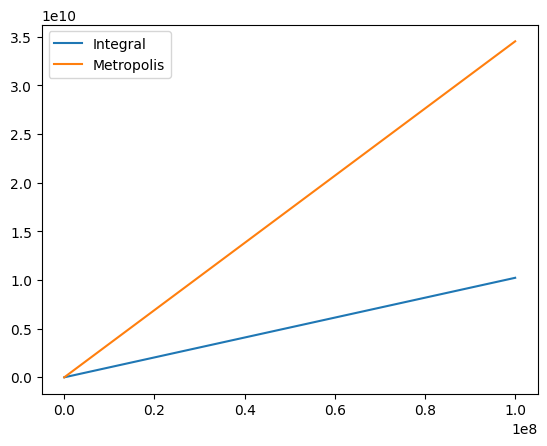

In [103]:
plt.plot(steps, times_integral, label='Integral')
plt.plot(steps, times_metropolis, label='Metropolis')
plt.legend()

## Generator function implementation

In [104]:
def generator_integral(num_trial):
    step = 1.0 / num_trial
    for j in range(num_trial):
        x = (j - 0.5) * step
        yield 4.0 / (1.0 + x * x)

def compute_pi_integral_gen(num_trial):
    return sum(generator_integral(num_trial)) * step        


def generator_metropolis(num_trial, seed):
    random.seed(seed)

    for _ in range(num_trial):
        x_val = random.random()
        y_val = random.random()

        radius = x_val ** 2 + y_val ** 2
        if radius < 1.0:
            yield 1
        else:
            yield 0

def compute_pi_metropolis_gen(num_trial, seed):
    return 4.0 * sum(generator_metropolis(num_trial, seed)) / num_trial


In [105]:
steps = [100, 10000, 1000000, 100000000]
times_integral_gen = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral_gen(step)
    times_integral_gen[i] = time_ns() - t0

print(times_integral_gen)

100%|██████████| 4/4 [00:12<00:00,  3.19s/it]

[0.00000000e+00 1.00100000e+06 1.27028000e+08 1.26478483e+10]


In [106]:
steps = [100, 10000, 1000000, 100000000]
times_metropolis_gen = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_metropolis_gen(step, 10)
    times_metropolis_gen[i] = time_ns() - t0

print(times_metropolis)

100%|██████████| 4/4 [00:37<00:00,  9.27s/it]

[0.00000000e+00 4.00090000e+06 3.45078400e+08 3.45327796e+10]


## Lambda function implementation

In [107]:
compute_pi_integral_lambda = lambda num_trial: sum([4.0 / (1.0 + ((j - 0.5) / num_trial) ** 2) for j in range(num_trial)]) / num_trial
compute_pi_metropolis_lambda = lambda num_trial: 4.0 * sum([1 for _ in range(num_trial) if (radius := random.random() ** 2 + random.random() ** 2) < 1.0]) / num_trial
compute_pi_metropolis_lambda_filter = lambda num_trial: 4.0 * len(list(filter(lambda: (random.random() ** 2 + random.random() ** 2) < 1, range(num_trial)))) / num_trial

In [108]:
steps = [100, 10000, 1000000, 100000000]
times_integral_lambda = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral_lambda(step)
    times_integral_lambda[i] = time_ns() - t0

print(times_integral_lambda)

100%|██████████| 4/4 [00:23<00:00,  5.98s/it]

[0.00000000e+00 1.99980000e+06 2.32053100e+08 2.36763329e+10]


In [109]:
steps = [100, 10000, 1000000, 100000000]
times_metropolis_lambda = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    random.seed(10)
    compute_pi_metropolis_lambda(step)
    times_metropolis_lambda[i] = time_ns() - t0

print(times_metropolis_lambda)

100%|██████████| 4/4 [00:37<00:00,  9.29s/it]

[0.0000000e+00 3.9999000e+06 3.4807950e+08 3.6823431e+10]


## Function implementation with Numpy

In [9]:
def compute_pi_integral_numpy(num_trial):
    step = 1.0 / num_trial
    tot = np.fromfunction(lambda j: 4.0 / (1.0 + ((j - 0.5) * step) ** 2), (num_trial,))
    return step * tot.sum()


def compute_pi_metropolis_numpy(num_trial, seed):
    random.seed(seed)
    vect = np.vectorize(lambda _: random.random() ** 2 + random.random() ** 2)
    tot = vect(np.zeros(num_trial))
    return 4.0 * np.sum(tot < 1.0) / num_trial

# TODO: Faire avec np.random.rand(num_trial) ** 2 + np.random.rand(num_trial) ** 2
# TODO: Faire sans from function mais avec np.arange(num_trial) puis les calculs sur tout le tableau
# TODO: Utiliser le random de numpy

In [10]:
steps = [100, 10000, 1000000, 100000000]
times_integral_numpy = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral_numpy(step)
    times_integral_numpy[i] = time_ns() - t0

print(times_integral_numpy)

100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

[8.002200e+06 0.000000e+00 3.200890e+07 2.256434e+09]


In [12]:
steps = [100, 10000, 1000000, 100000000]
times_metropolis_numpy = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    print(compute_pi_metropolis_numpy(step, 10))
    times_metropolis_numpy[i] = time_ns() - t0

print(times_metropolis_numpy)

  0%|          | 0/4 [00:00<?, ?it/s]

3.12
3.158


 75%|███████▌  | 3/4 [00:00<00:00,  7.11it/s]

3.143584


100%|██████████| 4/4 [00:44<00:00, 11.11s/it]

3.14174068
[1.00170000e+06 3.99970000e+06 4.17094100e+08 4.40049146e+10]


## Numba implementation

In [ ]:
#import numba

#@numba.jit(nopython=True)

## Pandas implementation

In [29]:
import pandas as pd

def compute_pi_integral_pandas(num_trial):
    step = 1.0 / num_trial
    tot = pd.Series(np.arange(num_trial))
    tot = 4.0 / (1.0 + ((tot - 0.5) * step) ** 2)
    return step * tot.sum()

def compute_pi_metropolis_pandas(num_trial, seed):
    random.seed(seed)
    tot = pd.Series(np.zeros(num_trial))
    tot = tot.apply(lambda _: random.random() ** 2 + random.random() ** 2)
    return 4.0 * (tot < 1.0).sum() / num_trial

# TODO: Utiliser vectorize

In [27]:
steps = [100, 10000, 1000000, 100000000]
times_integral_pandas = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral_pandas(step)
    times_integral_pandas[i] = time_ns() - t0

print(times_integral_pandas)

  0%|          | 0/4 [00:00<?, ?it/s]

3.161499736951264
3.1417926444218773
3.1415946535888777


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

3.1415926735898356
[2.9996000e+06 1.0000000e+06 1.6004100e+07 1.4863361e+09]


In [28]:
steps = [100, 10000, 1000000, 100000000]
times_metropolis_pandas = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_metropolis_pandas(step, 10)
    times_metropolis_pandas[i] = time_ns() - t0

print(times_metropolis_pandas)

  0%|          | 0/4 [00:00<?, ?it/s]

3.12
3.158


 75%|███████▌  | 3/4 [00:00<00:00,  6.11it/s]

3.143584


100%|██████████| 4/4 [00:49<00:00, 12.42s/it]

3.14174068
[3.00110000e+06 5.00070000e+06 4.83107700e+08 4.91600047e+10]


## Dask implementation

In [34]:
import dask.array as da

def compute_pi_integral_dask(num_trial):
    step = 1.0 / num_trial
    tot = da.arange(num_trial, chunks='auto')    
    tot = 4.0 / (1.0 + ((tot - 0.5) * step) ** 2)
    result = step * tot.sum()
    return result.compute()

def compute_pi_metropolis_dask(num_trial, seed):
    da.random.seed(seed)
    x_vals = da.random.random(num_trial, chunks='auto')
    y_vals = da.random.random(num_trial, chunks='auto')
    radius = x_vals ** 2 + y_vals ** 2
    result = 4.0 * (radius < 1.0).sum() / num_trial
    return result.compute()

# TODO: Utiliser vectorize

In [39]:
steps = [100, 10000, 1000000, 100000000]
times_integral_dask = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral_dask(step)
    times_integral_dask[i] = time_ns() - t0

print(times_integral_dask)

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

[7.000300e+06 8.002900e+06 2.100370e+07 7.261627e+08]


In [40]:
steps = [100, 10000, 1000000, 100000000]
times_metropolis_dask = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_metropolis_dask(step, 10)
    times_metropolis_dask[i] = time_ns() - t0

print(times_metropolis_dask)

100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

[9.002000e+06 9.002700e+06 2.700560e+07 8.221847e+08]


## Cython implementation

In [35]:
import cython
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [44]:
%%cython -a
import random
import numpy as np
from tqdm import tqdm
from time import time_ns
import matplotlib.pyplot as plt

def compute_pi_integral_cy(num_trial):
    cdef double step = 1.0 / num_trial
    cdef double tot = 0.0
    cdef double x = 0.0
    for j in range(int(num_trial)):
        x = (j - 0.5) * step
        tot = tot + 4.0 / (1.0 + x * x)
    return step * tot

def compute_pi_metropolis_cy(num_trial, seed):
    cdef double counter = 0.0
    random.seed(seed)

    for _ in range(int(num_trial)):
        x_val = random.random()
        y_val = random.random()

        radius = x_val ** 2 + y_val ** 2
        if radius < 1.0:
            counter += 1.0

    return 4.0 * counter / num_trial


steps = [100.0, 10000.0, 1000000.0, 100000000.0]
times_integral_cython = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_integral_cy(step)
    times_integral_cython[i] = time_ns() - t0

print(times_integral_cython)
np.save('times_integral_cython.npy', times_integral_cython)


steps = [100.0, 10000.0, 1000000.0, 100000000.0]
times_metropolis_cython = np.zeros(len(steps))

for i, step in enumerate(tqdm(steps)):
    t0 = time_ns()
    compute_pi_metropolis_cy(step, 10)
    times_metropolis_cython[i] = time_ns() - t0

print(times_metropolis_cython)
np.save('times_metropolis_cython.npy', times_metropolis_cython)

Content of stdout:
_cython_magic_b25e6a1d77958d26011fe6551f315626d0a701db.c
C:\Users\utilisateur\.ipython\cython\_cython_magic_b25e6a1d77958d26011fe6551f315626d0a701db.c(7180): warning C4244: '='ÿ: conversion de 'Py_ssize_t' en 'long', perte possible de donnes
   Cration de la bibliothque C:\Users\utilisateur\.ipython\cython\Users\utilisateur\.ipython\cython\_cython_magic_b25e6a1d77958d26011fe6551f315626d0a701db.cp312-win_amd64.lib et de l'objet C:\Users\utilisateur\.ipython\cython\Users\utilisateur\.ipython\cython\_cython_magic_b25e6a1d77958d26011fe6551f315626d0a701db.cp312-win_amd64.exp
Gnration de code en cours
Fin de la gnration du code

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[0.0000000e+00 0.0000000e+00 4.1008000e+07 4.1669388e+09]


100%|██████████| 4/4 [00:41<00:00, 10.40s/it]

[0.0000000e+00 4.0017000e+06 4.1009120e+08 4.1184303e+10]


In [45]:
times_integral = np.load('times_integral.npy')
times_integral_gen = np.load('times_integral_gen.npy')
times_integral_lambda = np.load('times_integral_lambda.npy')
times_integral_numpy = np.load('times_integral_numpy.npy')

times_metropolis = np.load('times_metropolis.npy')
times_metropolis_gen = np.load('times_metropolis_gen.npy')
times_metropolis_lambda = np.load('times_metropolis_lambda.npy')
times_metropolis_numpy = np.load('times_metropolis_numpy.npy')

[0.0000000e+00 0.0000000e+00 4.1008000e+07 4.1669388e+09]
[0.0000000e+00 4.0017000e+06 4.1009120e+08 4.1184303e+10]


In [46]:
plt.plot(steps, times_integral, label='Integral')
plt.plot(steps, times_integral_gen, label='Integral Gen')
plt.plot(steps, times_integral_lambda, label='Integral Lambda')
plt.plot(steps, times_integral_numpy, label='Integral Numpy')
plt.plot(steps, times_integral_cython, label='Integral Cython')

plt.plot(steps, times_metropolis, label='Metropolis')
plt.plot(steps, times_metropolis_gen, label='Metropolis Gen')
plt.plot(steps, times_metropolis_lambda, label='Metropolis Lambda')
plt.plot(steps, times_metropolis_numpy, label='Metropolis Numpy')
plt.plot(steps, times_metropolis_cython, label='Metropolis Cython')

plt.legend()

NameError: name 'times_integral' is not defined